### Model Building 

In [1]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, MaxPooling1D,Layer,Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, Add, RepeatVector, TimeDistributed,concatenate
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import regularizers
#from tensorflow.compact.v1.keras.layers import Attention
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

Using TensorFlow backend.


from google.colab import drive
drive.mount('/content/drive')

In [2]:
df = pd.read_excel('processed_trimmed_data.xlsx',sheet_name='Sheet1',encoding="utf-8",dtype="str")

In [3]:
df["new_group_56"] = df["new_group_55"].apply(lambda x: "GRP_0" if x == "GRP_8" else x)
df1 = df[df["new_group_56"]!="GRP_0"]
#df1 = df[df["new_group_56"]!="GRP_9999"]

In [4]:
df["new_group_85"].value_counts()

GRP_0       3959
GRP_9999    1270
GRP_8        661
GRP_24       289
GRP_12       257
GRP_9        252
GRP_2        241
GRP_19       214
GRP_3        200
GRP_6        184
GRP_13       144
GRP_10       139
GRP_5        129
GRP_14       118
GRP_25       116
GRP_33       107
GRP_4        100
Name: new_group_85, dtype: int64

In [44]:
df["new_group_56"].value_counts()

GRP_0       4620
GRP_9999    3760
Name: new_group_56, dtype: int64

In [6]:
maxlen_s = 20
maxlen_l = 40
maxlen_combo = 100
embedding_size = 200
numword1 = 6000
numword2 = 8000
numword3 = 13000

In [7]:
def prepare_token(data,numword):
  t = Tokenizer(num_words=numword)
  t.fit_on_texts(data)
  print("Tokenization process...F1.2..", len(t.word_index)) 
  return (t)

In [8]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [9]:
def Glv_model(data,t):
  #print("Preparing GloVe vector...F1.3 .. token as input", len(t.word_index))
  embeddings = {}  
  if len(embeddings)==0:
    EMBEDDING_FILE = 'glove.6B.200d.txt'
    embeddings = dict()
    f = open(EMBEDDING_FILE,encoding='Latin-1')
    for line in (f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:])
        embeddings[word] = coefs
    f.close()
  print("Glove being used:",len(embeddings))
  
  word_index = t.word_index
  print("t.word_index shape", len(t.word_index))  
  embedding_matrix = np.zeros((t.num_words, embedding_size))
  #print("Embedding Matrix Shape : ", embedding_matrix.shape )
  for word, i in tqdm(word_index.items()):
    if i < t.num_words:
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
            #if i < 2 : print(i,embedding_matrix[i])
  return(embedding_matrix)

In [10]:
#Tokenization and Embedding Process

t1 = prepare_token(df["trimmed_words_short"],numword1)
t2 = prepare_token(df["trimmed_words_long"],numword2)
t3 = prepare_token(df["Caller"]+" "+df["trimmed_words_short"]+" "+df["trimmed_words_long"],numword3)

embedding_matrix1 = Glv_model(df["trimmed_words_short"],t1)
embedding_matrix2 = Glv_model(df["trimmed_words_long"],t2)
embedding_matrix3 = Glv_model(df["trimmed_words_short"]+" "+df["trimmed_words_long"],t3)



Tokenization process...F1.2.. 5809
Tokenization process...F1.2.. 12988
Tokenization process...F1.2.. 16808


 19%|█▉        | 1121/5809 [00:00<00:00, 10595.52it/s]

Glove being used: 399955
t.word_index shape 5809


  9%|▉         | 1143/12988 [00:00<00:01, 11097.61it/s]

Glove being used: 399955
t.word_index shape 12988


  7%|▋         | 1215/16808 [00:00<00:01, 11019.38it/s]

Glove being used: 399955
t.word_index shape 16808


100%|██████████| 16808/16808 [00:00<00:00, 35470.62it/s]


In [11]:
len(df["trimmed_words_short"]+" "+df["trimmed_words_long"])

8380

In [12]:
print(t1.num_words)
print(len(t1.word_counts))
print(t2.num_words)
print(len(t2.word_counts))
print(t3.num_words)
print(len(t3.word_counts))



6000
5809
8000
12988
13000
16808


In [13]:
oversample = SMOTE()
undersample = NearMiss()
## Data Preparation
X_short_t = t3.texts_to_sequences(df["trimmed_words_short"])
X_long_t = t3.texts_to_sequences(df["trimmed_words_long"])
X_combo_t = t3.texts_to_sequences(df["Caller"]+" "+df["trimmed_words_short"]+" "+df["trimmed_words_long"])

X_short = pad_sequences(X_short_t, maxlen=maxlen_s, padding = 'post', truncating = 'post')
X_long = pad_sequences(X_long_t, maxlen=maxlen_l, padding = 'post', truncating = 'post')
X_combo = pad_sequences(X_combo_t,maxlen= maxlen_combo, padding = 'post', truncating='post')

X_short_u,y_u = undersample.fit_resample(X_short,df["new_group_75"])
X_short_o,y_o = oversample.fit_resample(X_short,df["new_group_75"])

onehot_encoder1 = OneHotEncoder(sparse=False)
y = onehot_encoder1.fit_transform(np.array(df["Assignment group"]).reshape(len(df["Assignment group"]),1))
onehot_encoder2 = OneHotEncoder(sparse=False)
y_75 = onehot_encoder2.fit_transform(np.array(df["new_group_75"]).reshape(len(df["new_group_75"]),1))
onehot_encoder3 = OneHotEncoder(sparse=False)
y_85 = onehot_encoder3.fit_transform(np.array(df["new_group_85"]).reshape(len(df["new_group_85"]),1))
onehot_encoder4 = OneHotEncoder(sparse=False)
y_95 = onehot_encoder4.fit_transform(np.array(df["new_group_95"]).reshape(len(df["new_group_95"]),1))
onehot_encoder5 = OneHotEncoder(sparse=False)
y_55 = onehot_encoder5.fit_transform(np.array(df["new_group_55"]).reshape(len(df["new_group_55"]),1))
onehot_encoder6 = OneHotEncoder(sparse=False)
y_56 = onehot_encoder6.fit_transform(np.array(df["new_group_56"]).reshape(len(df["new_group_56"]),1))


Groups = len(df["Assignment group"].value_counts())
Groups_75 = len(df["new_group_75"].value_counts())
Groups_85 = len(df["new_group_85"].value_counts())
Groups_95 = len(df["new_group_95"].value_counts())

# Split features into training and validation sets
X_train_s, X_val_s, X_train_l,X_val_l,X_train_combo,X_val_combo, y_train, y_val,y_train_75,y_val_75,y_train_85,y_val_85,y_train_95,y_val_95,y_train_55,y_val_55,y_train_56,y_val_56 = train_test_split(X_short,X_long,X_combo,y,y_75,y_85,y_95,y_55,y_56, test_size=0.20, random_state=15)

print("X_train_s Shape : ",X_train_s.shape)
print("X_train_l Shape : ",X_train_l.shape)
print("X_train_combo Shape : ",X_train_combo.shape)

print("y_train Shape : ",y_train.shape)
print("Group counts : ",Groups,Groups_75,Groups_85,Groups_95)


X_train_s Shape :  (6704, 20)
X_train_l Shape :  (6704, 40)
X_train_combo Shape :  (6704, 100)
y_train Shape :  (6704, 74)
Group counts :  74 10 17 33


In [14]:
onehot_encoder1 = OneHotEncoder(sparse=False)
y_o = onehot_encoder1.fit_transform(np.array(y_o).reshape(len(y_o),1))
onehot_encoder2 = OneHotEncoder(sparse=False)
y_u = onehot_encoder2.fit_transform(np.array(y_u).reshape(len(y_u),1))

In [15]:
X_short[2],X_long[1],df["trimmed_words_short"][1]

(array([147,  56,  47,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]),
 array([  28,   58, 9289,  848,  544, 1069,   17,  580, 5604,    2,  303,
         316,  451,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]),
 'outlook')

In [16]:
df["new_group_56"].value_counts()

GRP_0       4620
GRP_9999    3760
Name: new_group_56, dtype: int64

In [19]:
## Build the Model

# Model with Short description..............
short_desc_input = Input(shape=(maxlen_combo,), dtype='int32',name = "1.0_Input_Layer")
print(short_desc_input)
embedded_sequences = Embedding(t3.num_words, embedding_size, weights = [embedding_matrix3], trainable = True, name='1.1_Embedding')(short_desc_input)
#embedded_sequences = Embedding(t3.num_words, embedding_size, trainable = True, name='1.1_Embedding')(short_desc_input)
conv = Conv1D(32,3,activation = "relu", padding="same")(embedded_sequences)
maxpool = MaxPooling1D(pool_size=2)(conv)
short_lstm = Bidirectional(LSTM(128, return_sequences=True, dropout=0.5 ),name = "1.2_Bidirectional")(maxpool)
short_flatten = Flatten(name="1.5_Flatten")(short_lstm)
#description_vector = Dense(254, activation='relu',name = "3.2_Dense",
#                          kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(short_flatten)
droupout2 = Dropout(0.5)(short_flatten)
preds = Dense(10, activation='sigmoid',name = "3.3_Dense")(droupout2)

#Final model and compiling.................
model = Model(short_desc_input, preds)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.001), metrics=['acc', 'mse'])
#model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])
model.summary()  


Tensor("1.0_Input_Layer_1:0", shape=(?, 100), dtype=int32)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1.0_Input_Layer (InputLayer) [(None, 100)]             0         
_________________________________________________________________
1.1_Embedding (Embedding)    (None, 100, 200)          2600000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 32)           19232     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
1.2_Bidirectional (Bidirecti (None, 50, 256)           164864    
_________________________________________________________________
1.5_Flatten (Flatten)        (None, 12800)             0         
_________________________________________________________________


In [20]:
# Run the model....
reduce_lr = (ReduceLROnPlateau(monitor='val_acc', factor=0.2,
                              patience=1, min_lr=0.00000001))
early_stop = (EarlyStopping(monitor='val_acc', patience= 3))

history = model.fit(X_train_combo, y_train_75, 
                    validation_data=[X_val_combo,y_val_75], 
                    epochs=50, batch_size=4,callbacks= ([reduce_lr,early_stop]), verbose = 1)

Train on 6704 samples, validate on 1676 samples
Epoch 1/50
6704/6704 [==============================] - 194s 29ms/sample - loss: 1.1731 - acc: 0.6101 - mean_squared_error: 0.0754 - val_loss: 0.9820 - val_acc: 0.6539 - val_mean_squared_error: 0.0627
Epoch 2/50
6704/6704 [==============================] - 202s 30ms/sample - loss: 0.8689 - acc: 0.6982 - mean_squared_error: 0.0520 - val_loss: 0.8881 - val_acc: 0.6850 - val_mean_squared_error: 0.0546
Epoch 3/50
6704/6704 [==============================] - 195s 29ms/sample - loss: 0.7304 - acc: 0.7470 - mean_squared_error: 0.0486 - val_loss: 0.8305 - val_acc: 0.7082 - val_mean_squared_error: 0.0545
Epoch 4/50
6704/6704 [==============================] - 196s 29ms/sample - loss: 0.6324 - acc: 0.7831 - mean_squared_error: 0.0524 - val_loss: 0.8193 - val_acc: 0.7160 - val_mean_squared_error: 0.0586
Epoch 5/50
6704/6704 [==============================] - 199s 30ms/sample - loss: 0.5546 - acc: 0.8079 - mean_squared_error: 0.0551 - val_loss: 0.847

In [46]:
##Run the model.... with 56% classification we did 
## Build the Model

# Model with Short description..............
short_desc_input = Input(shape=(maxlen_combo,), dtype='int32',name = "1.0_Input_Layer")
print(short_desc_input)
embedded_sequences = Embedding(t3.num_words, embedding_size, weights = [embedding_matrix3], trainable = True, name='1.1_Embedding')(short_desc_input)
#embedded_sequences = Embedding(t3.num_words, embedding_size, trainable = True, name='1.1_Embedding')(short_desc_input)
conv = Conv1D(32,3,activation = "relu", padding="same")(embedded_sequences)
maxpool = MaxPooling1D(pool_size=2)(conv)
short_lstm = Bidirectional(LSTM(128, return_sequences=True, dropout=0.5 ),name = "1.2_Bidirectional")(maxpool)
short_flatten = Flatten(name="1.5_Flatten")(short_lstm)
#description_vector = Dense(254, activation='relu',name = "3.2_Dense",
#                          kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(short_flatten)
droupout2 = Dropout(0.5)(short_flatten)
preds = Dense(2, activation='sigmoid',name = "3.3_Dense")(droupout2)

#Final model and compiling.................
model = Model(short_desc_input, preds)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.001), metrics=['acc', 'mse'])
#model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])
model.summary() 

# Run the model.... with 56% classification we did 
reduce_lr = (ReduceLROnPlateau(monitor='val_acc', factor=0.2,
                              patience=1, min_lr=0.00000001))
early_stop = (EarlyStopping(monitor='val_acc', patience= 3))

history3 = model.fit(X_train_combo, y_train_56, 
                    validation_data=[X_val_combo,y_val_56], 
                    epochs=50, batch_size=4,callbacks= ([reduce_lr,early_stop]), verbose = 1)

Tensor("1.0_Input_Layer_3:0", shape=(?, 100), dtype=int32)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1.0_Input_Layer (InputLayer) [(None, 100)]             0         
_________________________________________________________________
1.1_Embedding (Embedding)    (None, 100, 200)          2600000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 32)           19232     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
1.2_Bidirectional (Bidirecti (None, 50, 256)           164864    
_________________________________________________________________
1.5_Flatten (Flatten)        (None, 12800)             0         
_________________________________________________________________


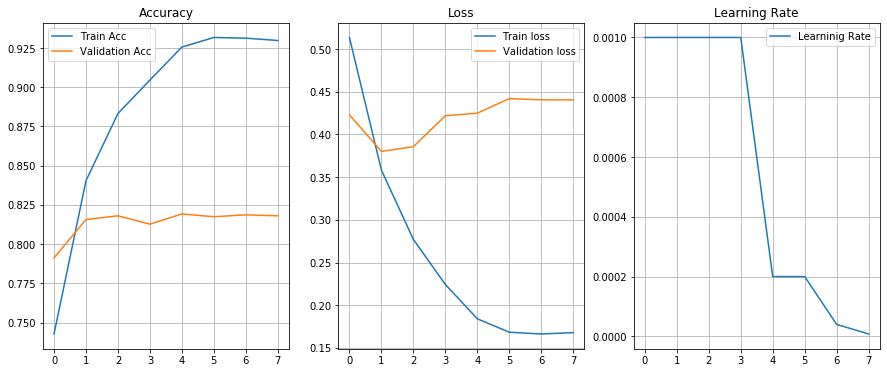

In [47]:
fig = plt.figure(figsize = (15, 6))
plt.subplot(1, 3, 1)
plt.plot(history3.history['acc'], label='Train Acc')
plt.plot(history3.history['val_acc'], label='Validation Acc')
#print("\n Data set : "+D+" & "+T+";  No of Output Groups: "+str(Groups)+" ; GloVe vector used : "+glv+"; Attention :"+attention1)
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(history3.history['loss'], label='Train loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(history3.history['lr'], label='Learninig Rate')
plt.title("Learning Rate")
plt.legend()
plt.grid()


plt.show()

Tensor("1.0_Input_Layer_4:0", shape=(?, 100), dtype=int32)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1.0_Input_Layer (InputLayer) [(None, 100)]             0         
_________________________________________________________________
1.1_Embedding (Embedding)    (None, 100, 200)          2600000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 32)           19232     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
1.2_Bidirectional (Bidirecti (None, 50, 256)           164864    
_________________________________________________________________
1.5_Flatten (Flatten)        (None, 12800)             0         
_________________________________________________________________


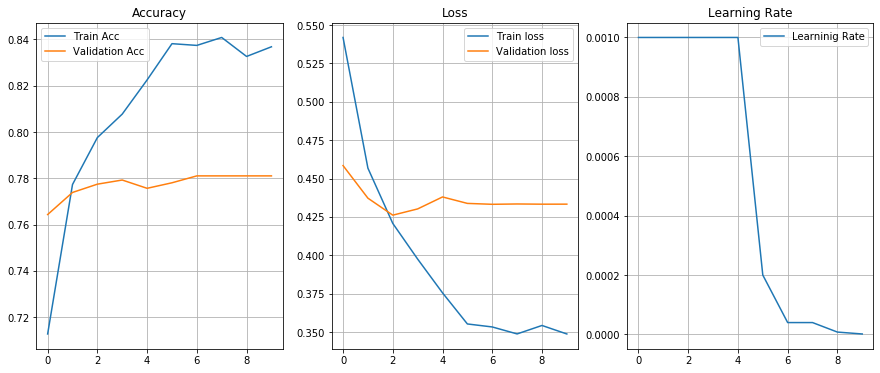

In [48]:
##Run the model.... with 56% classification we did with trainable = Fase
## Build the Model

# Model with Short description..............
short_desc_input = Input(shape=(maxlen_combo,), dtype='int32',name = "1.0_Input_Layer")
print(short_desc_input)
embedded_sequences = Embedding(t3.num_words, embedding_size, weights = [embedding_matrix3], trainable = False, name='1.1_Embedding')(short_desc_input)
#embedded_sequences = Embedding(t3.num_words, embedding_size, trainable = True, name='1.1_Embedding')(short_desc_input)
conv = Conv1D(32,3,activation = "relu", padding="same")(embedded_sequences)
maxpool = MaxPooling1D(pool_size=2)(conv)
short_lstm = Bidirectional(LSTM(128, return_sequences=True, dropout=0.5 ),name = "1.2_Bidirectional")(maxpool)
short_flatten = Flatten(name="1.5_Flatten")(short_lstm)
#description_vector = Dense(254, activation='relu',name = "3.2_Dense",
#                          kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(short_flatten)
droupout2 = Dropout(0.5)(short_flatten)
preds = Dense(2, activation='sigmoid',name = "3.3_Dense")(droupout2)

#Final model and compiling.................
model = Model(short_desc_input, preds)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.001), metrics=['acc', 'mse'])
#model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])
model.summary() 

# Run the model.... with 56% classification we did 
reduce_lr = (ReduceLROnPlateau(monitor='val_acc', factor=0.2,
                              patience=1, min_lr=0.00000001))
early_stop = (EarlyStopping(monitor='val_acc', patience= 3))

history3 = model.fit(X_train_combo, y_train_56, 
                    validation_data=[X_val_combo,y_val_56], 
                    epochs=50, batch_size=4,callbacks= ([reduce_lr,early_stop]), verbose = 1)

fig = plt.figure(figsize = (15, 6))
plt.subplot(1, 3, 1)
plt.plot(history3.history['acc'], label='Train Acc')
plt.plot(history3.history['val_acc'], label='Validation Acc')
#print("\n Data set : "+D+" & "+T+";  No of Output Groups: "+str(Groups)+" ; GloVe vector used : "+glv+"; Attention :"+attention1)
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(history3.history['loss'], label='Train loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(history3.history['lr'], label='Learninig Rate')
plt.title("Learning Rate")
plt.legend()
plt.grid()


plt.show()

In [49]:
y_pred = model.predict(X_val_combo)
a = np.argmax(y_pred,axis = 1)
b = np.argmax(y_val_56,axis = 1)
print(confusion_matrix(a,b))
print(classification_report(a,b))

[[684 148]
 [219 625]]
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       832
           1       0.81      0.74      0.77       844

    accuracy                           0.78      1676
   macro avg       0.78      0.78      0.78      1676
weighted avg       0.78      0.78      0.78      1676



In [29]:
## Build the Model with the Trainable Parameter False

# Model with Short description..............
short_desc_input = Input(shape=(maxlen_combo,), dtype='int32',name = "1.0_Input_Layer")
print(short_desc_input)
embedded_sequences = Embedding(t3.num_words, embedding_size, weights = [embedding_matrix3], trainable = False, name='1.1_Embedding')(short_desc_input)
#embedded_sequences = Embedding(t3.num_words, embedding_size, trainable = True, name='1.1_Embedding')(short_desc_input)
conv = Conv1D(32,3,activation = "relu", padding="same")(embedded_sequences)
maxpool = MaxPooling1D(pool_size=2)(conv)
short_lstm = Bidirectional(LSTM(128, return_sequences=True, dropout=0.5 ),name = "1.2_Bidirectional")(maxpool)
short_flatten = Flatten(name="1.5_Flatten")(short_lstm)
#description_vector = Dense(254, activation='relu',name = "3.2_Dense",
#                          kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(short_flatten)
droupout2 = Dropout(0.5)(short_flatten)
preds = Dense(10, activation='sigmoid',name = "3.3_Dense")(droupout2)

#Final model and compiling.................
model1 = Model(short_desc_input, preds)
model1.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.001), metrics=['acc', 'mse'])
#model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])
model1.summary()  


Tensor("1.0_Input_Layer_2:0", shape=(?, 100), dtype=int32)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1.0_Input_Layer (InputLayer) [(None, 100)]             0         
_________________________________________________________________
1.1_Embedding (Embedding)    (None, 100, 200)          2600000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 32)           19232     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
1.2_Bidirectional (Bidirecti (None, 50, 256)           164864    
_________________________________________________________________
1.5_Flatten (Flatten)        (None, 12800)             0         
_________________________________________________________________


In [30]:
# Run the model....
reduce_lr = (ReduceLROnPlateau(monitor='val_acc', factor=0.2,
                              patience=1, min_lr=0.00000001))
early_stop = (EarlyStopping(monitor='val_acc', patience= 3))

history1 = model1.fit(X_train_combo, y_train_75, 
                    validation_data=[X_val_combo,y_val_75], 
                    epochs=50, batch_size=4,callbacks= ([reduce_lr,early_stop]), verbose = 1)

Train on 6704 samples, validate on 1676 samples
Epoch 1/50
6704/6704 [==============================] - 196s 29ms/sample - loss: 1.1944 - acc: 0.5961 - mean_squared_error: 0.0690 - val_loss: 1.0019 - val_acc: 0.6665 - val_mean_squared_error: 0.0575
Epoch 2/50
6704/6704 [==============================] - 194s 29ms/sample - loss: 0.9727 - acc: 0.6608 - mean_squared_error: 0.0562 - val_loss: 0.9382 - val_acc: 0.6671 - val_mean_squared_error: 0.0585
Epoch 3/50
6704/6704 [==============================] - 196s 29ms/sample - loss: 0.8896 - acc: 0.6854 - mean_squared_error: 0.0535 - val_loss: 0.8992 - val_acc: 0.6856 - val_mean_squared_error: 0.0600
Epoch 4/50
6704/6704 [==============================] - 195s 29ms/sample - loss: 0.8476 - acc: 0.6939 - mean_squared_error: 0.0548 - val_loss: 0.8822 - val_acc: 0.6939 - val_mean_squared_error: 0.0575
Epoch 5/50
6704/6704 [==============================] - 196s 29ms/sample - loss: 0.8150 - acc: 0.7103 - mean_squared_error: 0.0548 - val_loss: 0.882

In [36]:
y_pred = model1.predict(X_val_combo)

In [37]:
a = np.argmax(y_pred,axis = 1)
b = np.argmax(y_val_75,axis = 1)

In [38]:
from sklearn.metrics import * 

In [39]:
print(confusion_matrix(a,b))

[[715  14  23  20   8  26   0   1   4 106]
 [  0  23   0   2   1   0   0   2   0  16]
 [  1   0   4   0   0   3   0   0   0   0]
 [  0   0   0  13   0   0   0   0   0   7]
 [  1   1   2   0  28   3   0   1   0   4]
 [  4   0   2   0   0   5   0   0   0   1]
 [  0   0   0   0   0   0   1   0   0   0]
 [  0   1   0   0   0   0  32 120  36  46]
 [  0   0   0   0   0   0   0   0   0   0]
 [ 51  10  12  21   9  11   9   7   8 261]]


In [40]:
print(classification_report(a,b))

              precision    recall  f1-score   support

           0       0.93      0.78      0.85       917
           1       0.47      0.52      0.49        44
           2       0.09      0.50      0.16         8
           3       0.23      0.65      0.34        20
           4       0.61      0.70      0.65        40
           5       0.10      0.42      0.17        12
           6       0.02      1.00      0.05         1
           7       0.92      0.51      0.66       235
           8       0.00      0.00      0.00         0
           9       0.59      0.65      0.62       399

    accuracy                           0.70      1676
   macro avg       0.40      0.57      0.40      1676
weighted avg       0.81      0.70      0.74      1676



C:\Users\deppr\.conda\envs\gpu_v2\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
onehot_encoder2.categories_

[array(['GRP_0', 'GRP_12', 'GRP_19', 'GRP_2', 'GRP_24', 'GRP_3', 'GRP_6',
        'GRP_8', 'GRP_9', 'GRP_9999'], dtype=object)]

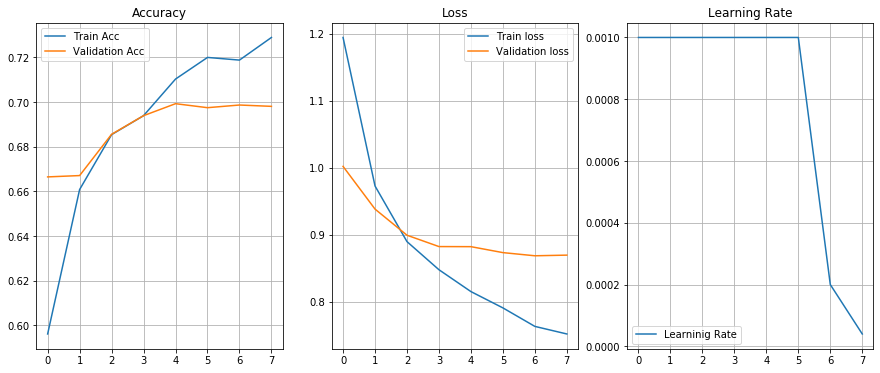

In [42]:
fig = plt.figure(figsize = (15, 6))
plt.subplot(1, 3, 1)
plt.plot(history.history['acc'], label='Train Acc')
plt.plot(history.history['val_acc'], label='Validation Acc')
#print("\n Data set : "+D+" & "+T+";  No of Output Groups: "+str(Groups)+" ; GloVe vector used : "+glv+"; Attention :"+attention1)
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(history.history['lr'], label='Learninig Rate')
plt.title("Learning Rate")
plt.legend()
plt.grid()


plt.show()